In [ ]:
!pip install poutyne
!pip install segmentation-models-pytorch
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

Number of training samples: 800
Number of validation samples: 100
Number of test samples: 100


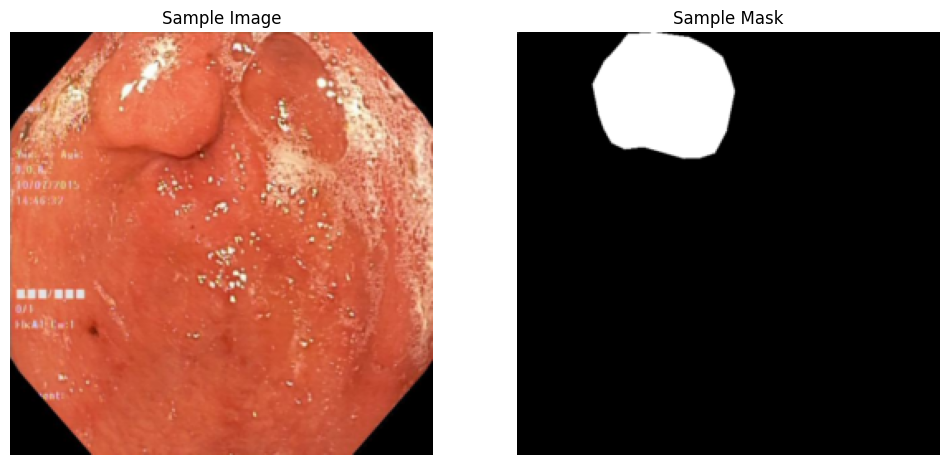

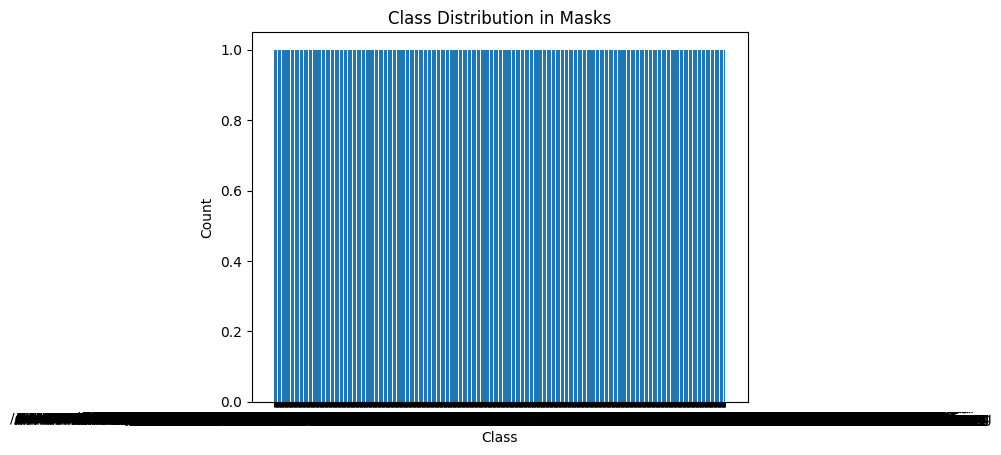

Image Mean: 94.73546509629854, Image Std: 6.708045589553
Mask Mean: 39.24729294751334, Mask Std: 26.596990385331928


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import segmentation_models_pytorch as smp
import poutyne as pyt
from poutyne.framework import ModelCheckpoint, EarlyStopping
from sklearn.metrics import jaccard_score, f1_score

dataset_root = '/content/drive/My Drive/Kvasir-SEG/'
images_df = dataset_root + 'images'
masks_df = dataset_root + 'masks'

class SegmentationDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx])
        mask = Image.open(self.mask_paths[idx])

        # Convert mask to a single channel mask if it's not already
        if mask.mode != 'L':
            mask = mask.convert('L')

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

image_paths = sorted([os.path.join(images_df, img) for img in os.listdir(images_df)])
mask_paths = sorted([os.path.join(masks_df, mask) for mask in os.listdir(masks_df)])

X_train, X_temp, y_train, y_temp = train_test_split(image_paths, mask_paths, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

transform = transforms.Compose([transforms.Resize((256, 256)),
                                transforms.ToTensor()])

train_dataset = SegmentationDataset(X_train, y_train, transform=transform)
val_dataset = SegmentationDataset(X_val, y_val, transform=transform)
test_dataset = SegmentationDataset(X_test, y_test, transform=transform)

batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

#EDA
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(val_dataset)}")
print(f"Number of test samples: {len(test_dataset)}")
import random

# Visualize a random sample from the training dataset
idx = random.randint(0, len(train_dataset) - 1)
sample_image, sample_mask = train_dataset[idx]
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Sample Image")
plt.imshow(sample_image.permute(1, 2, 0))  # Transpose the tensor to (H, W, C) format
plt.axis('off')
plt.subplot(1, 2, 2)
plt.title("Sample Mask")
plt.imshow(sample_mask.squeeze(), cmap='gray')  # Squeeze to remove the single channel dimension
plt.axis('off')
plt.show()

# Calculate and plot the class distribution in the training masks
mask_class_distribution = np.unique(np.array(y_train), return_counts=True)
classes, counts = mask_class_distribution
plt.bar(classes, counts)
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Class Distribution in Masks")
plt.show()

# Calculate mean and standard deviation of pixel values in images and masks
image_mean = np.mean([np.array(Image.open(img)).mean() for img in image_paths])
image_std = np.std([np.array(Image.open(img)).std() for img in image_paths])
mask_mean = np.mean([np.array(Image.open(mask)).mean() for mask in mask_paths])
mask_std = np.std([np.array(Image.open(mask)).std() for mask in mask_paths])
print(f"Image Mean: {image_mean}, Image Std: {image_std}")
print(f"Mask Mean: {mask_mean}, Mask Std: {mask_std}")

In [3]:
model = smp.UnetPlusPlus(encoder_name="efficientnet-b0", encoder_weights="imagenet", in_channels=3, classes=1)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
metrics = ['iou', 'dice']
model = pyt.Model(model, optimizer, loss_fn, device = 'cuda')
callbacks = [ModelCheckpoint("best_model.pth", monitor="val_loss", save_best_only=True),
             EarlyStopping(monitor="val_loss", patience=10)]
history = model.fit_generator(train_loader,
                              val_loader,
                              epochs=20,
                              callbacks=callbacks)

Epoch:  1/20 Train steps: 50 Val steps: 7 31.23s loss: 0.369087 val_loss: 0.222089
Epoch:  2/20 Train steps: 50 Val steps: 7 29.24s loss: 0.146484 val_loss: 0.173791
Epoch:  3/20 Train steps: 50 Val steps: 7 28.25s loss: 0.097941 val_loss: 0.173016
Epoch:  4/20 Train steps: 50 Val steps: 7 27.67s loss: 0.086377 val_loss: 0.161792
Epoch:  5/20 Train steps: 50 Val steps: 7 28.64s loss: 0.066740 val_loss: 0.121671
Epoch:  6/20 Train steps: 50 Val steps: 7 28.00s loss: 0.059823 val_loss: 0.108427
Epoch:  7/20 Train steps: 50 Val steps: 7 28.19s loss: 0.049816 val_loss: 0.124034
Epoch:  8/20 Train steps: 50 Val steps: 7 27.70s loss: 0.043382 val_loss: 0.122369
Epoch:  9/20 Train steps: 50 Val steps: 7 28.13s loss: 0.048809 val_loss: 0.145186
Epoch: 10/20 Train steps: 50 Val steps: 7 27.45s loss: 0.060578 val_loss: 0.186212
Epoch: 11/20 Train steps: 50 Val steps: 7 27.47s loss: 0.048614 val_loss: 0.151647
Epoch: 12/20 Train steps: 50 Val steps: 7 27.69s loss: 0.038044 val_loss: 0.106242
Epoc

IoU: 0.7692552079327554, Dice: 0.8890467736206574


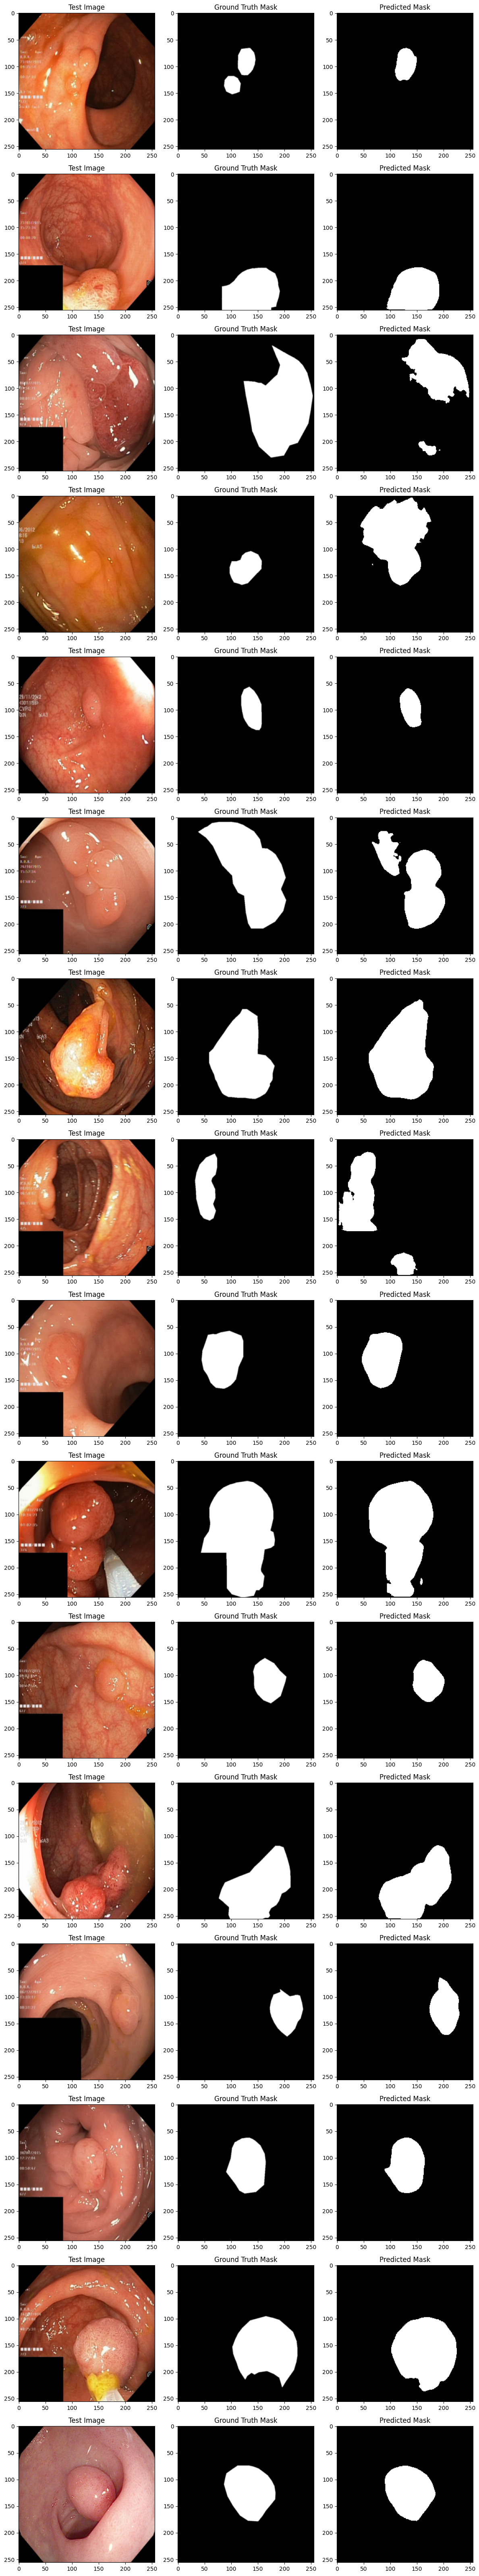

In [20]:
def calculate_iou(y_true, y_pred):
    intersection = torch.logical_and(y_true, y_pred).sum()
    union = torch.logical_or(y_true, y_pred).sum()
    iou = (intersection.float() + 1e-6) / (union.float() + 1e-6)
    return iou.item()

def calculate_dice(y_true, y_pred):
    intersection = torch.logical_and(y_true, y_pred).sum()
    dice = (2.0 * intersection.float() + 1e-6) / (y_true.sum().float() + y_pred.sum().float() + 1e-6)
    return dice.item()

def evaluate_model(model, dataloader):
    model.eval()  # Set the model to evaluation mode
    iou_scores = []
    dice_scores = []

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to('cuda'), targets.to('cuda')

            outputs = model(inputs)
            predictions = (outputs > 0.5).float()

            iou_batch = []
            dice_batch = []

            for i in range(len(inputs)):
                iou = calculate_iou(targets[i], predictions[i])
                dice = calculate_dice(targets[i], predictions[i])
                iou_batch.append(iou)
                dice_batch.append(dice)

            iou_scores.extend(iou_batch)
            dice_scores.extend(dice_batch)

    model.train()  # Set the model back to training mode

    avg_iou = sum(iou_scores) / len(iou_scores)
    avg_dice = sum(dice_scores) / len(dice_scores)

    return avg_iou, avg_dice

iou, dice = evaluate_model(model, test_loader)
print(f"IoU: {iou}, Dice: {dice}")

def plot_images_with_masks(images, masks, predictions):
    num_samples = len(images)
    fig, axes = plt.subplots(nrows=num_samples, ncols=3, figsize=(12, 4*num_samples))

    for i in range(num_samples):
        axes[i, 0].imshow(images[i].permute(1, 2, 0))  # Display the test image
        axes[i, 0].set_title('Test Image')

        axes[i, 1].imshow(masks[i].squeeze(), cmap='gray')  # Display the ground truth mask
        axes[i, 1].set_title('Ground Truth Mask')

        axes[i, 2].imshow(predictions[i].squeeze(), cmap='gray')  # Display the predicted mask
        axes[i, 2].set_title('Predicted Mask')

    plt.tight_layout()
    plt.show()

# Load a batch of test data
for inputs, targets in test_loader:
    inputs, targets = inputs.to('cuda'), targets.to('cuda')
    outputs = model(inputs)
    predictions = (outputs > 0.5).float()
    break  # Break after processing one batch

# Plot the images and masks
plot_images_with_masks(inputs.cpu(), targets.cpu(), predictions.cpu())